## Project Description
Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. 

As players progress through the game, they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. 

In this project, we will analyze the result of an **A/B test** where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on **player retention**.

## Acknowledgements
This dataset is taken from DataCamp. Thanks to them for this dataset!

## Workflow:
1. Data Collection
2. Data Pre-Processing and Analysis
3. 

### Importing the Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### Loading the dataset

In [2]:
cookie_users = pd.read_csv('datasets/cookie_cats.csv')

In [3]:
cookie_users.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
cookie_users.shape

(90189, 5)

#### Dataset Content
The data we have includes 90,189 players that installed the game while the AB-test was running. When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

#### Variables:

- *userid*: A unique number that identifies each player.

- *version*: Whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).

- *sum_gamerounds*: the number of game rounds played by the player during the first 14 days after install.

- *retention_1*: Did the player come back and play 1 day after installing?

- *retention_7*: Did the player come back and play 7 days after installing?



### Exploratory Data Analysis

In [5]:
cookie_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [6]:
cookie_users.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [7]:
# check missing values
cookie_users.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [8]:
cookie_users.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [9]:
cookie_users.version.value_counts()

gate_40    45489
gate_30    44700
Name: version, dtype: int64

In [10]:
# check if there are repeated users
len(cookie_users.userid.unique())

90189

In [11]:
# check if version has some impacts on sum_gamerounds
cookie_users.groupby('version').mean()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,4.987564e+06,52.456264,0.448188,0.190201
gate_40,5.009073e+06,51.298776,0.442283,0.182000


In [12]:
cookie_users.groupby('version').sum()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,222944098441,2344795,20034,8502
gate_40,227857702576,2333530,20119,8279


<Figure size 300x300 with 0 Axes>

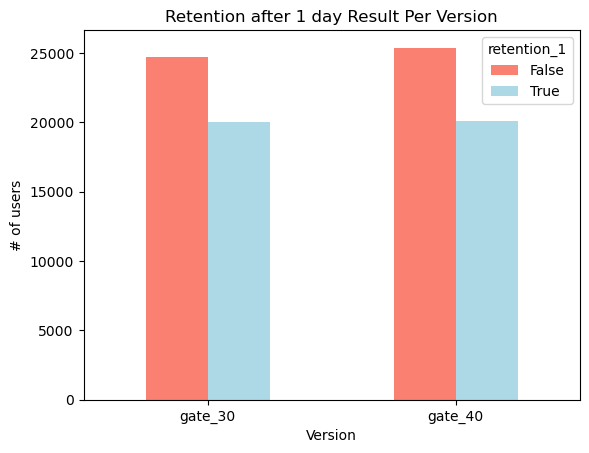

In [20]:
plt.figure(figsize = (3, 3))

# Make the crosstab visual
pd.crosstab(cookie_users.version, cookie_users.retention_1).plot(kind = 'bar', color = ['salmon', 'lightblue'])

# Add some communication
plt.title('Retention after 1 day Result Per Version')
plt.xlabel('Version')
plt.ylabel('# of users')
# plt.legend(['False', 'True'])
plt.xticks(rotation = 0);

<Figure size 300x300 with 0 Axes>

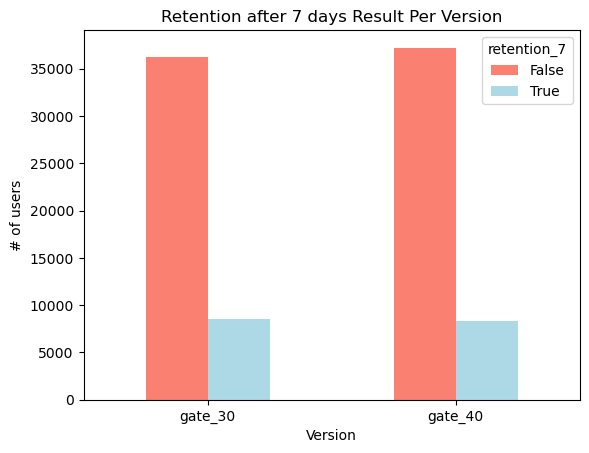

In [21]:
plt.figure(figsize = (3, 3))

# Make the crosstab visual
pd.crosstab(cookie_users.version, cookie_users.retention_7).plot(kind = 'bar', color = ['salmon', 'lightblue'])

# Add some communication
plt.title('Retention after 7 days Result Per Version')
plt.xlabel('Version')
plt.ylabel('# of users')
# plt.legend(['False', 'True'])
plt.xticks(rotation = 0);

### Calculate the Sample Size
